In [2]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d.art3d import Line3DCollection
import plotly.graph_objects as go 
from matplotlib import ticker
import math

###   

###   

 ###  2021-05-10 Goals

In [4]:
##$Big ticket item
#rearrange code to be future compatible by making data processing and visualization into two modules
#This might be done by assigning processed dataframes to global variables that can be called by the graphing functions 
#depending on user input
##check list items
#$Store values in dictionary to be called by function 
#$remove unneccessary axis label tags ("x2" to "x" and ax2 --> ax) 
#ax = fig.add_subplot(111) #learn this in depth for future subplot endeavors
#$make code easier to read (no long lines)
#$set ticks to exist within a pixel or nm range of -1 to 1 and -100 nm to 100 nm

### Two Modules

filename: RecBCD_plain2.csv    |  pixel_size: 154  |  time_step: 20
frame_start: 0  |    frame_end: -1  |  bin_size: 3
processing: none  |  plot_type: 2D  |  title: testing 2
X_axis_label: X  |  Y_axis_label: Y  |  Z_axis_label: Time (ms)


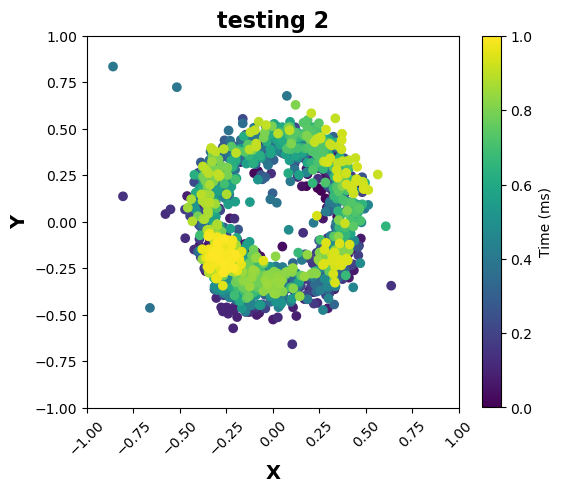

In [47]:
parameters = {
'file_name': "RecBCD_plain2.csv",
'pixel_size': 154, # in nanometers
'time_step': 20, # in miliseconds
'frame_start': 0, # enter 0 to start from beginning of dataset
'frame_end': -1, # enter -1 to end at the last value of the data set
'bin_size': 3, # bin size for downsample/filter processing
'processing': "none", # enter downsample, filter, or none
'plot_type': "2D", # enter 2D, 3D, or interactive
'title': "testing 2",
'x_axis_label': "X",
'y_axis_label': "Y",
'z_axis_label': "Time (ms)",
'unit': "pixel"}    # enter pixel or nm 

def display_trajectory_v2(file_name,pixel_size,time_step,frame_start,frame_end,bin_size,processing,plot_type,title,x_axis_label,y_axis_label,z_axis_label,unit):
       
        print(*['filename:', file_name, '   | ' , 'pixel_size:', pixel_size , ' | ' , 'time_step:', time_step])
        
        print(*['frame_start:', frame_start,' |   ','frame_end:', frame_end, ' | ', 'bin_size:', bin_size])
        
        print(*['processing:', processing, ' | ',  'plot_type:', plot_type,' | ' ,'title:', title])
        
        print(*['X_axis_label:',x_axis_label,' | ',  'Y_axis_label:',y_axis_label ,' | ' ,'Z_axis_label:', z_axis_label])
        
        
    
        #read data file into a pandas data frame, add an index counter, and label columns
        data = pd.read_csv(file_name, header = None)
        data['index'] = range(len(data))
        data.columns = [ 'X position', 'Y position','index']
        data=data[['index','X position','Y position']]

        # find the average of X and Y column respectively
        ave = data.mean(axis=0)
        xave = ave.loc['X position']
        yave = ave.loc['Y position']

        #substract averages from each column to find displacement, store into new columns
        data["X displacement (pixels)"] = data['X position'] - xave
        data["Y displacement (pixels)"] = data['Y position'] - yave
        # mutiply pixel displacement columns by scaler to find nm displacement, store in new columns
        data["X displacement (nm)"] = data['X displacement (pixels)']*pixel_size
        data["Y displacement (nm)"]= data['Y displacement (pixels)']*pixel_size
        # multiply the index counter column by time_step to make a time step column, store into new column 
        data["Time (ms)"] = data['index']*time_step
        
        
        
        
        
        ##Simple Moving Average or "filter" dataframe:
        ma = pd.DataFrame(data.iloc[:,0])

        window = bin_size
        #Built in simple moving average function is applied to normal data and stored in dataframe "ma"
        ma['X movement' ] = data.iloc[:,1].rolling(window=window).mean()
        ma['Y movement'] = data.iloc[:,2].rolling(window=window).mean()
        ma['X displacement (pixels)'] = data.iloc[:,3].rolling(window=window).mean()
        ma['Y displacement(pixels)'] = data.iloc[:,4].rolling(window=window).mean()
        ma['X displacement (nm)'] = data.iloc[:,5].rolling(window=window).mean()
        ma['Y displacement (nm)'] = data.iloc[:,6].rolling(window=window).mean()
        ma['Time (ms)'] = data.iloc[:,7].rolling(window=window).mean()

        #This block delets the null spaces in the new dataframe and realigns the data
        ma = ma.apply (pd.to_numeric, errors='coerce')
        ma = ma.dropna()
        ma = ma.reset_index(drop=True)
        
        
        
        
        
        ##Downsampling dataframe:
        da=pd.DataFrame(data.iloc[:,:])
        #divide original index by sample size and round to nearest whole number to 
        #achieve new index number underwhich the origial index is stored
        u= math.floor(frame_start/bin_size)
        v= math.floor(frame_end/bin_size)

        #isolate the column (if we print this it will show as a dataframe with 2 cols: indexes and time values)
        daT_column=da.iloc[:,7]
        daDY_column=da.iloc[:,6]
        daDX_column=da.iloc[:,5]
        daPY_column=da.iloc[:,4]
        daPX_column=da.iloc[:,3]
        daI_column=da.iloc[:,0]
        daX_column=da.iloc[:,1]
        daY_column=da.iloc[:,2]
        #We just want the values in the column
        daT = daT_column.values
        daDY = daDY_column.values
        daDX = daDX_column.values
        daPY = daPY_column.values
        daPX = daPX_column.values
        daI = daI_column.values
        daX = daX_column.values
        daY= daY_column.values
        #This function taken from https://stackoverflow.com/questions/10847660/subsampling-averaging-over-a-numpy-array
        # allows us to downsample by averages over a set number 
        #(change 'n' to the number of values you want to average over)
        def average(arr, n):
            end =  n * int(len(arr)/n)
            return np.mean(arr[:end].reshape(-1, n), 1)
        #Takes the time column from our 'da' dataframe and runs the function over it
        #stores the new values in variables as an array (values in a row)

        #assigning each new row to a varialble
        Time = average(daT,bin_size)
        Index = average(daI,bin_size)
        Xda = average(daX,bin_size)
        Yda = average(daY,bin_size)
        Ydisnm = average(daDY,bin_size)
        Xdisnm = average(daDX,bin_size)
        YdisP = average(daPY,bin_size)
        XdisP = average(daPX,bin_size)

        #reshaping the data in a 1D column
        TimeT = Time[:, np.newaxis]
        YdisnmT = Ydisnm[:, np.newaxis]
        XdisnmT = Xdisnm[:, np.newaxis]
        YdisPT = YdisP[:, np.newaxis]
        XdisPT = XdisP[:,np.newaxis]
        XdaT = Xda[:, np.newaxis]
        YdaT = Yda[:,np.newaxis]
        IndexT = Index[:,np.newaxis]

        #stores in a new dataframe 'dsak' for: downsampling average k, k=bin size
        dsa= pd.DataFrame(IndexT, columns=['Index'])
        #appending to our data frame
        dsa['X movement'] = XdaT
        dsa['Y movement'] = YdaT
        dsa['X displacement (pixels)'] = XdisPT
        dsa['Y displacement (pixels)'] = YdisPT
        dsa['X displacement (nm)'] = XdisnmT 
        dsa['Y displacement (nm)'] = YdisnmT
        dsa['Time (ms)'] = TimeT
        
        #future processing methods to be added below:
        
        
        
        
        
        #DETERMINE PROCESSING AND UNIT TYPE:
        #if more processing methods are to be added, an if statement must be
        #added with a key word to select that data frame
        if processing == "none":
            df = data
        if processing == "filter":
            df = ma
        if processing == "downsample":
            df = dsa
            frame_start= math.floor(frame_start/bin_size)
            frame_end= math.floor(frame_end/bin_size)
            
        # Here the code determines the units of the graph    
        if unit == "pixel":
            x_unit = 3
            y_unit = 4
        if unit == "nm":
            x_unit = 5
            y_unit = 6
        
        #assign values of x y and z
        x = df.iloc[frame_start:frame_end,x_unit] # move this outside this block to apply for all "none"
        y = df.iloc[frame_start:frame_end,y_unit]
        z = df.iloc[frame_start:frame_end,7] #col 7 is the time col #check this!
        
        
        
        #GRAPHING BLOCK
            
        if plot_type == "2D":
               

            #plot sizing and location
            fig = plt.figure(figsize=(6,6), dpi=100)
            ax = fig.add_subplot(111)#121 # 1X1 grid plot 1, subplot(222) would be 2X2 grid plot 2, (223)--> 2X2 plot 3
            
            #color bar color scheme assignment, graph type, colorbar size and alignment
            colors = cm.viridis(np.linspace(0, 1, len(z)))
            p=ax.scatter(x, y, c=colors)
            cbar = plt.colorbar(p, label= z_axis_label ,shrink= .82) #

            #setting the ticks on the colorbar to span the length of the time column with 6 increments
            cbar.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1]) #

            tix = np.linspace(0,len(z),6)
            tix_c = tix*time_step
            #cbar.set_ticklabels(tix_c) #
            plt.axis('square')
            plt.xticks(rotation=45)
            
            #set graph limit conditions depending on unit specified
            if unit == "pixel":
                ax.set_xlim(-1, 1) 
                ax.set_ylim(-1, 1)
                ax.yaxis.set_major_locator(ticker.LinearLocator(9))# change to 5 for increments of .5
                ax.xaxis.set_major_locator(ticker.LinearLocator(9))
            if unit == "nm":
                ax.set_xlim(-150, 150) 
                ax.set_ylim(-150, 150)
                ax.yaxis.set_major_locator(ticker.LinearLocator(6))
                ax.xaxis.set_major_locator(ticker.LinearLocator(6))
            
            


            #axis labels and font configurations
            ax.set_xlabel(x_axis_label, fontweight = 'bold', fontsize = 14)
            ax.set_ylabel(y_axis_label, fontweight = 'bold', fontsize = 14)

            # plot title and font configurations
            plt.title(title , fontweight = 'bold', fontsize = 16)
            
            
            
            
            #### PLAY WITH SUBPLOT
            #ax2 = fig.add_subplot(1,j,i) # j=(call it panels or subplots) total number of subplots as determined by user # i is iteration max i goes from 0 to j
            #colors2 = cm.plasma(np.linspace(0, 1, len(z)))
            #p2=ax2.scatter(x, y, c=colors2)
            #cbar2 = plt.colorbar(p2, label= z_axis_label ,shrink= .82) 

            #setting the ticks on the colorbar to span the length of the time column with 6 increments
            #cbar2.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1])

            
            #tix = np.linspace(0,len(z),6)
            #tix_c = tix*time_step
            #cbar2.set_ticklabels(tix_c)
            #plt.axis('square')
            #plt.xticks(rotation=45)
            
            #set graph limit conditions depending on unit specified
            #if unit == "pixel":
                #ax2.set_xlim(-1, 1) 
                #ax2.set_ylim(-1, 1)
                #ax2.yaxis.set_major_locator(ticker.LinearLocator(9))# change to 5 for increments of .5
                #ax2.xaxis.set_major_locator(ticker.LinearLocator(9))
            #if unit == "nm":
                #ax2.set_xlim(-150, 150) 
                #ax2.set_ylim(-150, 150)
                #ax2.yaxis.set_major_locator(ticker.LinearLocator(6))
                #ax2.xaxis.set_major_locator(ticker.LinearLocator(6))
            
            


            #axis labels and font configurations
            #ax2.set_xlabel(x_axis_label, fontweight = 'bold', fontsize = 14)
            #ax2.set_ylabel(y_axis_label, fontweight = 'bold', fontsize = 14)
            #plt.title("copy" , fontweight = 'bold', fontsize = 16)

            
            
            
            
            #plt.savefig('date_file_name.png', dpi=300)

            plt.show()



        #This block plots a static 3D graph if prompt is met
        if plot_type == "3D":


            #This block splices the segments between data points and assigns each segment to a color
            points = np.array([x,y,z]).transpose().reshape(-1,1,3)
            segs = np.concatenate([points[:-1],points[1:]],axis=1)
            lc = Line3DCollection(segs, cmap = plt.get_cmap('cool'))
            lc.set_array(z)

            #This block plots the figure at a specified size, in 3D configuration, sets axis range, gathers the 
            #colored segments from above, and assigns labels
            fig = plt.figure(figsize=(8,8))
            ax = fig.gca(projection = '3d')
            ax.set_zlim(min(z), max(z))
            if unit == "pixel":
                ax.set_xlim(-1,1)
                ax.set_ylim(-1,1)
            if unit == "nm":
                ax.set_xlim(-150,150)
                ax.set_ylim(-150,150)
            ax.add_collection3d(lc, zs=z, zdir='z')
            plt.title(title , fontweight = 'bold', fontsize= 16)
            ax.set_xlabel(x_axis_label, fontweight = 'bold', fontsize = 14)
            ax.set_ylabel(y_axis_label , fontweight = 'bold', fontsize = 14)
            ax.set_zlabel(z_axis_label, fontweight= 'bold' , fontsize =14)

            #plt.savefig('date_file_name.png',dpi=300)

            plt.show()


        if plot_type == "interactive":

            #configure plot settings (currently called trace 1, may add more traces in the future)
            trace1=go.Scatter3d(x=x,
                                y=y,
                                z=z,
                                mode = "lines",
                                name = 'Original',
                                marker=dict(
                                    size=4,
                                    color='#e9ebf0',
                                    opacity=0.7,
                                    showscale=False,
                                    colorbar=dict(
                                        title='Time (ms)')),
                                line=dict(
                                    color='#e9ebf0',
                                    width=2))
            #assign traces
            fig = go.Figure(data=[trace1])

            #assign title
            fig.update_layout(title= title)
            #assign axis labels
            fig.update_layout(scene = dict(
                        xaxis_title= x_axis_label,
                        yaxis_title= y_axis_label,
                        zaxis_title= z_axis_label)) 

            #Here we can tweak the background color, grid color, and color of the origin for all axes/plane
            fig.update_layout(scene = dict(
                        xaxis = dict(
                             backgroundcolor="black",
                             gridcolor="gray",
                             showbackground=True,
                             zerolinecolor="white",),
                        yaxis = dict(
                            backgroundcolor="black",
                            gridcolor="gray",
                            showbackground=True,
                            zerolinecolor="white"),
                        zaxis = dict(
                            backgroundcolor="black",
                            gridcolor="gray",
                            showbackground=True,
                            zerolinecolor="white"),),
                      )

            #size and aspect ratio of the graph and the default camera zoom and angle 
            fig.update_layout(
            width=800,
            height=700,
            autosize=False,
            scene=dict(
            camera=dict(
                up=dict(
                    x=0,
                    y=0,
                    z=1
                ),
                eye=dict(
                    x=1,
                    y=2,
                    z=2,
                )
            ),
            aspectratio = dict( x=1, y=1, z=4 ),
            aspectmode = 'manual'
            ),
            )
            
            

            fig.show()
        #return print(data)




        
display_trajectory_v2(**parameters)

In [ ]:
#goals
#replace print out of parameters with a clean looking table # not that important
#fig.update_layout(yaxis_range=[-1,1])
#fig.update_layout(xaxis_range=[-1,1]) # for interactive plot???


#goals from 5/24/21
##Big Ticket Item(s)
# add subplot option to graphing module
# Make a "for" loop that iterates through specified number (n) of subplots determined by the user
# This loop needs to divide the data into (n) parts (data frames) (chronology preserved) to be called by the graphing
# module which uses this data to make n subplots
## check list item(s)
# decimal points on time label must go!
